# Import Packages

In [3]:
import numpy as np
import pandas as pd
import re
from functools import reduce
from scipy.stats import pearsonr
import matplotlib.ticker as mticker

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
reviews = pd.read_csv('edu_services_google_reviews.csv')
edu1 = pd.read_csv('Education-services-au-export.csv')

# Import Dataset & Cleaning
**AEDC** 

The Australian Early Development Census (AEDC) dataset contains information about the developmental status of children in different Local Government Areas (LGAs) across several domains (such as physical health, social competence, emotional maturity, language and cognitive skills, and communication skills).
- identify which LGAs have the highest proportions of developmentally vulnerable children (DV1, DV2).
- analyze disparities in child development outcomes across regions and domains.
- compare these outcomes with socio-economic and geographic factors.

**Google Reviews**

For education-related service providers (such as preschools and childcare centers).
- perform sentiment analysis and understand public perception of education services.
- assess the quality of services from the perspective of parents and the community.
- explore the relationship between review sentiment/ratings and AEDC outcomes.

**LGA Time-Series**

Time-series data for various AEDC domains and subdomains at the LGA level, often including multiple years of data.
What it’s used for:
- analyze trends and changes in child development outcomes over time.
- compare progress or decline in different LGAs and domains.
- support longitudinal analysis for policy evaluation.

**Education Services** 

Detailed information about education service providers, including their names, locations, types, quality ratings (such as NQS), and accessibility features.
- map the distribution and accessibility of education services across LGAs.
- analyze the alignment between service quality/availability and AEDC outcomes.
- investigate whether areas with more or higher-quality services have better child development outcomes.


## LGA (lga)

In [5]:
sheet = pd.ExcelFile('LGA 2009-21.xlsx').sheet_names
print(sheet)
sheet

['Contents', 'LGA Health', 'LGA Social', 'LGA Emotional', 'LGA Language', 'LGA Communication', 'LGA One or more', 'LGA Two or more', 'LGA On track all', 'LGA Health 1 Subdomain', 'LGA Health 2 Subdomain', 'LGA Health 3 Subdomain']


['Contents',
 'LGA Health',
 'LGA Social',
 'LGA Emotional',
 'LGA Language',
 'LGA Communication',
 'LGA One or more',
 'LGA Two or more',
 'LGA On track all',
 'LGA Health 1 Subdomain',
 'LGA Health 2 Subdomain',
 'LGA Health 3 Subdomain']

Developmentally vulnerable refers to the total number of children in each LGA and each year who participated in the assessment for a given domain and received a valid score.

We only retain the percentage of developmentally vulnerable children, as this allows for direct comparison of vulnerability levels across different LGAs, years, and domains, without being affected by the total number of children in each area.

The number (n) is only suitable for examining absolute scale, but does not reflect the relative severity.

In [6]:
lga_xlsx = pd.ExcelFile('LGA 2009-21.xlsx')
sheet_names = [ 'LGA Health',
                'LGA Social',
                'LGA Emotional',
                'LGA Language',
                'LGA Communication',
                'LGA One or more',
                'LGA Two or more']

states_to_remove = [
    "New South Wales", "Victoria", "Queensland",
    "Western Australia", "South Australia",
    "Tasmania", "Australian Capital Territory", "Northern Territory"
]

lga_dict = {}
for name in sheet_names:
    lga_dict[name] = pd.read_excel(lga_xlsx, sheet_name=name, skiprows=4)
    lga_dict[name] = lga_dict[name].drop(lga_dict[name].columns[0], axis=1) # delete the empty column

    lga_percent = lga_dict[name].iloc[:, [0, 1, -9, -7, -5, -3, -1]] # filter developmentally vulnerable
    lga_percent.columns = ['Code', 'Name', '2009', '2012', '2015', '2018', '2021']  # rename columns

    lga_percent = lga_percent[~lga_percent['Code'].astype(str).isin(states_to_remove)] # remove the state rows
    lga_percent = lga_percent.rename(columns={'Name': 'Suburb'}) # rename suburb col
    lga_percent = lga_percent.dropna()

    lga_dict[name] = lga_percent.reset_index(drop=True)


In [7]:
for sheet in sheet_names:
    print(f"Sheet: {sheet}")
    print(lga_dict[sheet].head())
    print('-' * 100)

Sheet: LGA Health
    Code             Suburb       2009       2012       2015       2018  \
0  10050             Albury  10.221465   10.25641   7.783418  12.460064   
1  10180  Armidale Regional  11.079545  14.164306   8.064516  13.489736   
2  10250            Ballina   8.297872   7.121662   4.608295   8.492569   
3  10300          Balranald   6.451613   6.451613  12.121212   3.448276   
4  10470  Bathurst Regional   9.766454  11.111111   8.949416  11.372549   

        2021  
0  11.402157  
1   12.37785  
2   6.965174  
3  33.333333  
4  15.953307  
----------------------------------------------------------------------------------------------------
Sheet: LGA Social
    Code             Suburb       2009       2012       2015       2018  \
0  10050             Albury  11.754685  12.820513  10.490694  15.335463   
1  10180  Armidale Regional   9.943182  12.464589   6.774194   9.677419   
2  10250            Ballina  11.914894   7.121662   8.064516   9.766454   
3  10300          Balr

In [8]:
domain_map = {
    'LGA Health': 'Health',
    'LGA Social': 'Social',
    'LGA Emotional': 'Emotional',
    'LGA Language': 'Language',
    'LGA Communication': 'Communication',
    'LGA One or more': 'DV1',
    'LGA Two or more': 'DV2'
}

for name in lga_dict:
    prefix = domain_map[name]
    lga_dict[name] = lga_dict[name].rename(
        columns={year: f"{prefix}_{year}" for year in ['2009', '2012', '2015', '2018', '2021']}
    )

dfs = list(lga_dict.values())
lga = reduce(lambda left, right: pd.merge(left, right, on=['Code', 'Suburb'], how='outer'), dfs)

# Separate column for year
lga = pd.melt(lga,id_vars=['Code', 'Suburb'],var_name='Domain_Year',value_name='Percentage') # Merge all data frames horizontally
lga[['Domain', 'Year']] = lga['Domain_Year'].str.split('_', expand=True) # Split Domain_Year into Domain and Year
lga = lga[['Code', 'Suburb', 'Domain', 'Year', 'Percentage']] # Select the columns we want to keep
lga = lga.rename(columns={'Year': 'LGA_Year'}) 
lga = lga.rename(columns={'Percentage': 'Domain_pct'}) 
lga = lga.rename(columns={'Code': 'lga_code'}) 

lga.sample(20)

,lga_code,Suburb,Domain,LGA_Year,Domain_pct
3372,15900,Newcastle,Social,2012,7.110092
16185,40430,Barunga West,DV1,2021,37.5
13056,56580,Nedlands,Communication,2018,2.181818
13623,57980,Subiaco,Communication,2021,7.692308
3046,42030,Gawler,Social,2009,9.633028
16329,55390,Menzies,DV1,2021,*
12637,12160,Cootamundra-Gundagai Regional,Communication,2018,3.448276
10054,26170,South Gippsland,Language,2018,7.821229
9371,14100,Hunters Hill,Language,2015,2.209945
18782,22310,Glen Eira,DV2,2021,6.48688


The LGA dataset contains missing or suppressed values (e.g., , ≥90, blanks) due to insufficient valid scores or confidentiality requirements. In this analysis, we retain only numeric values. Suppressed values displayed as are assumed to represent a relatively low rate and are imputed as 1%. For interval values (e.g., ≥90), only the numeric part is retained. All other missing values are dropped.

In [9]:
def extract_number(val):
    if isinstance(val, str):
        if val.strip() == '*':
            return 1.0  # Impute suppressed values as 1%
        match = re.search(r'\d+\.?\d*', val) 
        if match:
            return float(match.group())  # Keep only the numeric part for intervals
        else:
            return None 
    return val

lga['Domain_pct'] = lga['Domain_pct'].apply(extract_number)
lga['Domain_pct'] = pd.to_numeric(lga['Domain_pct'], errors='coerce').round(4)
lga = lga.dropna(subset=['Domain_pct'])

print(lga.sample(20))

      lga_code              Suburb         Domain LGA_Year  Domain_pct
7049     58190              Tammin      Emotional     2015      1.0000
9778     57280        Port Hedland       Language     2015     14.7170
9785     57840         South Perth       Language     2015      3.2419
16974    72200           Katherine            DV2     2009     35.5828
2514     44620       Mount Gambier         Health     2021     14.8789
18995    50420           Bayswater            DV2     2021      8.0556
15162    50630          Boddington            DV1     2015     13.6364
3966     20260              Ararat         Social     2015      9.0090
9748     55040             Leonora       Language     2015     26.0870
4145     42600        Holdfast Bay         Social     2015      6.8729
6694     18020  Warrumbungle Shire      Emotional     2015     11.6505
2725     71300         East Arnhem         Health     2021     14.7059
3954     18020  Warrumbungle Shire         Social     2015     11.6505
18167 

In [10]:
lga['Suburb'] = lga['Suburb'].str.upper().str.replace(r'\s*\(.*?\)', '', regex=True)
lga['Suburb'] = lga['Suburb'].str.replace(r'[^A-Z0-9 ]', '', regex=True)
lga['Suburb'] = lga['Suburb'].str.replace(r'\s+', ' ', regex=True)
lga['Suburb'] = lga['Suburb'].str.strip()
lga = lga.dropna(subset=['Suburb'])
state = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']
pattern = r'\s*[\-\.]?\s*(' + '|'.join(state) + r')\.?$'
lga['Suburb'] = lga['Suburb'].str.replace(pattern, '', regex=True).str.strip()

lga['Suburb'].unique().tolist()

['ALBURY',
 'ARMIDALE REGIONAL',
 'BALLINA',
 'BALRANALD',
 'BATHURST REGIONAL',
 'BAYSIDE',
 'BEGA VALLEY',
 'BELLINGEN',
 'BERRIGAN',
 'BLACKTOWN',
 'BLAND',
 'BLAYNEY',
 'BLUE MOUNTAINS',
 'BOGAN',
 'BOURKE',
 'BREWARRINA',
 'BROKEN HILL',
 'BURWOOD',
 'BYRON',
 'CABONNE',
 'CAMDEN',
 'CAMPBELLTOWN',
 'CANADA BAY',
 'CANTERBURYBANKSTOWN',
 'CARRATHOOL',
 'CENTRAL COAST',
 'CENTRAL DARLING',
 'CESSNOCK',
 'CLARENCE VALLEY',
 'COBAR',
 'COFFS HARBOUR',
 'COOLAMON',
 'COONAMBLE',
 'COOTAMUNDRAGUNDAGAI REGIONAL',
 'COWRA',
 'CUMBERLAND',
 'DUBBO REGIONAL',
 'DUNGOG',
 'EDWARD RIVER',
 'EUROBODALLA',
 'FAIRFIELD',
 'FEDERATION',
 'FORBES',
 'GEORGES RIVER',
 'GILGANDRA',
 'GLEN INNES SEVERN',
 'GOULBURN MULWAREE',
 'GREATER HUME SHIRE',
 'GRIFFITH',
 'GUNNEDAH',
 'GWYDIR',
 'HAWKESBURY',
 'HAY',
 'HILLTOPS',
 'HORNSBY',
 'HUNTERS HILL',
 'INNER WEST',
 'INVERELL',
 'JUNEE',
 'KEMPSEY',
 'KIAMA',
 'KURINGGAI',
 'KYOGLE',
 'LACHLAN',
 'LAKE MACQUARIE',
 'LANE COVE',
 'LEETON',
 'LISMORE',


In [11]:
lga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19180 entries, 0 to 19179
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lga_code    19180 non-null  object 
 1   Suburb      19180 non-null  object 
 2   Domain      19180 non-null  object 
 3   LGA_Year    19180 non-null  object 
 4   Domain_pct  19180 non-null  float64
dtypes: float64(1), object(4)
memory usage: 749.3+ KB


## AEDC (aedc)

In [12]:
sheet1_names = ['Table_2', 'Table_3']
adec_dict = {}
for name1 in sheet1_names:
    df = pd.read_excel('42400DO002_2023.xlsx', sheet_name=name1, skiprows=57, nrows=1)
    df.columns = ['Category', 'NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT','AU']
    adec_dict[name1] = df

for sheet in sheet1_names:
    print(f"Sheet: {sheet}")
    print(adec_dict[sheet].head())

Sheet: Table_2
                                         Category     NSW    VIC    QLD  \
0  Total children enrolled in a preschool program  104887  97129  63125   

      SA     WA   TAS    NT   ACT      AU  
0  20051  34522  7616  3161  6819  337305  
Sheet: Table_3
                                       Category     NSW    VIC    QLD     SA  \
0  Total children attending a preschool program  103962  91507  61851  19668   

      WA   TAS    NT   ACT      AU  
0  32944  7519  2789  6696  326933  


In [13]:
enrollment = adec_dict['Table_2']
attendance = adec_dict['Table_3']

enroll_total_row = enrollment[enrollment['Category'].str.contains('Total children enrolled', case=False, na=False)].iloc[0]
attend_total_row = attendance[attendance['Category'].str.contains('Total children attending', case=False, na=False)].iloc[0]

states = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']

enrollment_au = float(enroll_total_row['AU'])
attendance_au = float(attend_total_row['AU'])

aedc = pd.DataFrame({'State': states})
aedc['Enrollment'] = [float(enroll_total_row[state]) for state in states]
aedc['Attendance'] = [float(attend_total_row[state]) for state in states]
aedc['Enrollment_pct'] = (aedc['Enrollment'] / enrollment_au * 100).round(4)
aedc['Attendance_pct'] = (aedc['Attendance'] / attendance_au * 100).round(4)

aedc = aedc[['State', 'Enrollment_pct', 'Attendance_pct']]
print(aedc)

  State  Enrollment_pct  Attendance_pct
0   NSW         31.0956         31.7992
1   VIC         28.7956         27.9895
2   QLD         18.7145         18.9186
3    SA          5.9445          6.0159
4    WA         10.2347         10.0767
5   TAS          2.2579          2.2999
6    NT          0.9371          0.8531
7   ACT          2.0216          2.0481


## Education Service Provides (edu)

| Keep | Remove (examples) |
|----------------------------------|--------------------------------------|
| ServiceApprovalNumber | Phone, Fax, Conditions on Approval |
| Provider Approval Number | All timetable/session columns |
| ServiceName, ProviderLegalName | PreviousQualityArea* columns |
| ServiceType, ServiceAddress | Other, Temporarily Closed |
| Suburb, State, Postcode | |
| NumberOfApprovedPlaces | |
| QualityArea1-7Rating, OverallRating, RatingsIssued | |
| Long Day Care, Preschool/Kindergarten, Outside school Hours Care | |


In [14]:
edu1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17663 entries, 0 to 17662
Data columns (total 97 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ServiceApprovalNumber                             17663 non-null  object 
 1   Provider Approval Number                          17663 non-null  object 
 2   ServiceName                                       17663 non-null  object 
 3   ProviderLegalName                                 17556 non-null  object 
 4   ServiceType                                       17663 non-null  object 
 5   ServiceAddress                                    17653 non-null  object 
 6   Suburb                                            17653 non-null  object 
 7   State                                             17653 non-null  object 
 8   Postcode                                          17653 non-null  float64
 9   Phone            

In [15]:
edu = edu1[
    [   
        'ServiceName',
        'ProviderLegalName',
        'ServiceType',
        'Suburb',
        'State',
        'Postcode',
        'NumberOfApprovedPlaces',
        'QualityArea1Rating',  # 1 - Educational program and practice
        'QualityArea2Rating',  # 2 - Children’s health and safety
        'QualityArea3Rating',  # 3 - Physical environment
        'QualityArea4Rating',  # 4 - Staffing arrangements
        'QualityArea5Rating',  # 5 - Relationships with children
        'QualityArea6Rating',  # 6 - Collaborative partnerships with families and communities
        'QualityArea7Rating',  # 7 - Governance and leadership
        'OverallRating',
        'RatingsIssued',
        'Long Day Care',
        'Preschool/Kindergarten - Part of a School',
        'Preschool/Kindergarten - Stand alone',
        'Outside school Hours Care - After School',
        'Outside school Hours Care - Before School',
        'Outside school Hours Care - Vacation Care'
    ]
]
edu.head()

,ServiceName,ProviderLegalName,ServiceType,Suburb,State,Postcode,NumberOfApprovedPlaces,QualityArea1Rating,QualityArea2Rating,QualityArea3Rating,QualityArea4Rating,QualityArea5Rating,QualityArea6Rating,QualityArea7Rating,OverallRating,RatingsIssued,Long Day Care,Preschool/Kindergarten - Part of a School,Preschool/Kindergarten - Stand alone,Outside school Hours Care - After School,Outside school Hours Care - Before School,Outside school Hours Care - Vacation Care
0,Community Kids Waterford Early Education Centre,G8 Education Limited,Centre-Based Care,WATERFORD WEST,QLD,4133.0,60.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Sep 2023,Yes,No,Yes,No,No,No
1,KIDVENTURE EARLY LEARNING EAGLEBY,Table Mountain Trading Pty Ltd As The Trustee ...,Centre-Based Care,EAGLEBY,QLD,4207.0,74.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Working Towards NQS,Meeting NQS,Meeting NQS,Working Towards NQS,Apr 2023,Yes,No,Yes,Yes,Yes,Yes
2,Community Kids - Broadbeach Waters,G8 Education Limited,Centre-Based Care,BROADBEACH WATERS,QLD,4217.0,75.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Dec 2022,Yes,No,Yes,No,No,No
3,Little Scholars School of Early Learning Burle...,The Scholars Group Pty Ltd,Centre-Based Care,BURLEIGH WATERS,QLD,4220.0,106.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Oct 2019,Yes,No,No,No,No,No
4,Small World Child Care Centre,A. & K. Massouras Pty. Ltd. ATF The A Massoura...,Centre-Based Care,CARRARA,QLD,4211.0,92.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Jul 2023,Yes,No,No,Yes,Yes,Yes


In [16]:
edu['Suburb'] = edu['Suburb'].str.upper()
edu['Suburb'] = edu['Suburb'].str.strip()
edu['Suburb'] = edu['Suburb'].str.replace(r'\s+', ' ', regex=True)
edu['Suburb'] = edu['Suburb'].str.replace(r'[^A-Z0-9 ]', '', regex=True)
edu['Suburb'].unique().tolist()

['WATERFORD WEST',
 'EAGLEBY',
 'BROADBEACH WATERS',
 'BURLEIGH WATERS',
 'CARRARA',
 'CURRUMBIN WATERS',
 'ELANORA',
 'HELENSVALE',
 'MERMAID WATERS',
 'MUDGEERABA',
 'WORONGARY',
 'NERANG',
 'OXENFORD',
 'ROBINA',
 'BILOELA',
 'MORANBAH',
 'CLERMONT',
 'BOWEN',
 'ACACIA RIDGE',
 'ALGESTER',
 'ASHGROVE',
 'ASPLEY',
 'BOONDALL',
 'BULIMBA',
 'CARINDALE',
 'CARINA',
 'CLAYFIELD',
 'COORPAROO',
 'ENOGGERA',
 'EVERTON PARK',
 'FORTITUDE VALLEY',
 'GRACEVILLE',
 'HOLLAND PARK',
 'INALA',
 'INDOOROOPILLY',
 'JINDALEE',
 'HERSTON',
 'KENMORE',
 'MCDOWALL',
 'MANLY',
 'MANLY WEST',
 'MANSFIELD',
 'MITCHELTON',
 'MOOROOKA',
 'MORNINGSIDE',
 'MOUNT GRAVATT',
 'NATHAN',
 'NEWMARKET',
 'NORTHGATE',
 'RED HILL',
 'RIVERHILLS',
 'RUNCORN',
 'ST LUCIA',
 'SANDGATE',
 'SHERWOOD',
 'SOUTH BRISBANE',
 'SPRING HILL',
 'STAFFORD',
 'CALAMVALE',
 'TARINGA',
 'TARRAGINDI',
 'EKIBIN',
 'THE GAP',
 'TINGALPA',
 'TOOWONG',
 'HILL END',
 'WEST END',
 'WILSTON',
 'WINDSOR',
 'WOOLLOONGABBA',
 'WYNNUM',
 'WYNNUM

In [17]:
edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17663 entries, 0 to 17662
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ServiceName                                17663 non-null  object 
 1   ProviderLegalName                          17556 non-null  object 
 2   ServiceType                                17663 non-null  object 
 3   Suburb                                     17653 non-null  object 
 4   State                                      17653 non-null  object 
 5   Postcode                                   17653 non-null  float64
 6   NumberOfApprovedPlaces                     17246 non-null  float64
 7   QualityArea1Rating                         16336 non-null  object 
 8   QualityArea2Rating                         16336 non-null  object 
 9   QualityArea3Rating                         16336 non-null  object 
 10  QualityArea4Rating    

## Reviews (reviews)

In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29427 entries, 0 to 29426
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             29427 non-null  object 
 1   TitleShownOnGoogleMaps  29427 non-null  object 
 2   overall_rating          29427 non-null  float64
 3   5 stars                 29248 non-null  float64
 4   4 stars                 29248 non-null  float64
 5   3 stars                 29248 non-null  float64
 6   2 stars                 29248 non-null  float64
 7   1 stars                 29248 non-null  float64
 8   individual_rating       29427 non-null  object 
 9   individual_comments     23321 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.2+ MB


In [19]:
reviews.head()

,ServiceName,TitleShownOnGoogleMaps,overall_rating,5 stars,4 stars,3 stars,2 stars,1 stars,individual_rating,individual_comments
0,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Sending our daughter to Chrysalis was the best...
1,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Chrysalis is an incredible daycare centre for ...
2,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,"My child loves attending Chrysalis, often not ..."
3,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,I have had the pleasure of all 3 of my kids at...
4,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Our daughter has absolutely thrived during her...


In [20]:
reviews = reviews.rename(columns={'individual_comments': 'comments'})

In [21]:
reviews = reviews[['ServiceName', 'TitleShownOnGoogleMaps', 'overall_rating', 'comments']]
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29427 entries, 0 to 29426
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             29427 non-null  object 
 1   TitleShownOnGoogleMaps  29427 non-null  object 
 2   overall_rating          29427 non-null  float64
 3   comments                23321 non-null  object 
dtypes: float64(1), object(3)
memory usage: 919.7+ KB


## SEIFA

In [22]:
seifa_path = pd.ExcelFile('Local Government Area, Indexes, SEIFA 2021.xlsx')
seifa_xls = pd.ExcelFile(seifa_path)
irsd_df = seifa_xls.parse('Table 2', skiprows=5)

seifa = irsd_df.iloc[:, [0, 1, 2, 3, 5]].copy()

seifa = seifa.rename(columns={
    seifa.columns[0]: 'lga_code',    # Column 0 renamed to lga_code
    seifa.columns[1]: 'Suburb',    # Column 1 renamed to lga_name
    seifa.columns[2]: 'Population',
    seifa.columns[3]: 'SEIFA_Score',
    seifa.columns[4]: 'SEIFA_Rank'
})
seifa = seifa.dropna(subset=['Population', 'SEIFA_Score'])

seifa = seifa.assign(
    **{
        'Population': seifa['Population'].astype('int'),
        'Suburb': seifa['Suburb'].str.upper(),
        'SEIFA_Score': seifa['SEIFA_Score'].round(4),
        'SEIFA_Rank': seifa['SEIFA_Rank'].astype('int'),
    }
)
seifa = seifa.reset_index(drop=True)
seifa.sample(20)

,lga_code,Suburb,Population,SEIFA_Score,SEIFA_Rank
67,14850,LISMORE,44334,965.5636,224
312,43220,KIMBA,1037,1019.5720,420
166,23940,LODDON,7759,948.1040,156
204,27260,WYNDHAM,292011,1005.5163,385
49,13550,GUNNEDAH,12929,966.6836,231
177,24970,MONASH,190397,1042.3084,478
365,50560,BEVERLEY,1694,955.9070,184
107,17350,TEMORA,6034,971.7356,244
32,12150,COONAMBLE,3732,883.2383,53
421,54310,KARRATHA,22199,1052.0090,494


# Merge

In [23]:
df = edu.merge(reviews, on='ServiceName', how='left') \
        .merge(lga, on='Suburb', how='left') \
        .merge(aedc, on='State', how='left') \
        .merge(seifa, on=['Suburb','lga_code'], how='left')

df.sample(5)

,ServiceName,ProviderLegalName,ServiceType,Suburb,State,Postcode,NumberOfApprovedPlaces,QualityArea1Rating,QualityArea2Rating,QualityArea3Rating,QualityArea4Rating,QualityArea5Rating,QualityArea6Rating,QualityArea7Rating,OverallRating,RatingsIssued,Long Day Care,Preschool/Kindergarten - Part of a School,Preschool/Kindergarten - Stand alone,Outside school Hours Care - After School,Outside school Hours Care - Before School,Outside school Hours Care - Vacation Care,TitleShownOnGoogleMaps,overall_rating,comments,lga_code,Domain,LGA_Year,Domain_pct,Enrollment_pct,Attendance_pct,Population,SEIFA_Score,SEIFA_Rank
121208,Kidz Klub,Kidz Klub Pty Ltd,Centre-Based Care,PENRITH,NSW,2750.0,90.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Jul 2024,No,No,No,Yes,Yes,Yes,Kids Clubhouse,4.6,Emily was a great hostess. Very attentive and ...,16350,Emotional,2012,6.8356,31.0956,31.7992,217664.0,991.2959,328.0
163855,Kids Academy Melton,Affinity Education Group Pty Limited,Centre-Based Care,MELTON,VIC,3337.0,128.0,Exceeding NQS,Exceeding NQS,Exceeding NQS,Exceeding NQS,Exceeding NQS,Meeting NQS,Meeting NQS,Exceeding NQS,Jul 2021,Yes,No,No,No,No,No,Kids Academy Early Learning Melton,4.3,Very friendly and professional and great facil...,24650,Social,2015,9.4421,28.7956,27.9895,178960.0,985.1879,298.0
94912,St Augustine's Parish School OSHC,South Australian Commission for Catholic Schoo...,Centre-Based Care,SALISBURY,SA,5108.0,130.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Mar 2021,No,No,No,Yes,Yes,Yes,St Augustine's Parish School,3.4,NaN,47140,Communication,2009,12.2794,5.9445,6.0159,145806.0,903.6654,69.0
130818,BDCS - Preschool (9a),Bourke & District Children's Services,Centre-Based Care,BOURKE,NSW,2840.0,39.0,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Oct 2024,Yes,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN,11150,Health,2009,14.0000,31.0956,31.7992,2340.0,946.6859,152.0
72701,SOS Preschool,SOS Preschool Incorporated,Centre-Based Care,RANDWICK,NSW,2031.0,65.0,Meeting NQS,Meeting NQS,Exceeding NQS,Exceeding NQS,Exceeding NQS,Exceeding NQS,Meeting NQS,Exceeding NQS,Oct 2019,No,No,Yes,No,No,No,NaN,NaN,NaN,16550,DV1,2012,15.6848,31.0956,31.7992,134252.0,1059.0591,502.0


In [24]:
df['Postcode'] = df['Postcode'].astype('Int64')
df['NumberOfApprovedPlaces'] = df['NumberOfApprovedPlaces'].astype('Int64')
df.drop_duplicates(inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176231 entries, 0 to 196353
Data columns (total 34 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   ServiceName                                176231 non-null  object 
 1   ProviderLegalName                          175750 non-null  object 
 2   ServiceType                                176231 non-null  object 
 3   Suburb                                     176221 non-null  object 
 4   State                                      176221 non-null  object 
 5   Postcode                                   176221 non-null  Int64  
 6   NumberOfApprovedPlaces                     174037 non-null  Int64  
 7   QualityArea1Rating                         165433 non-null  object 
 8   QualityArea2Rating                         165433 non-null  object 
 9   QualityArea3Rating                         165433 non-null  object 
 10  QualityArea4R

In [26]:
df.head()

,ServiceName,ProviderLegalName,ServiceType,Suburb,State,Postcode,NumberOfApprovedPlaces,QualityArea1Rating,QualityArea2Rating,QualityArea3Rating,QualityArea4Rating,QualityArea5Rating,QualityArea6Rating,QualityArea7Rating,OverallRating,RatingsIssued,Long Day Care,Preschool/Kindergarten - Part of a School,Preschool/Kindergarten - Stand alone,Outside school Hours Care - After School,Outside school Hours Care - Before School,Outside school Hours Care - Vacation Care,TitleShownOnGoogleMaps,overall_rating,comments,lga_code,Domain,LGA_Year,Domain_pct,Enrollment_pct,Attendance_pct,Population,SEIFA_Score,SEIFA_Rank
0,Community Kids Waterford Early Education Centre,G8 Education Limited,Centre-Based Care,WATERFORD WEST,QLD,4133,60,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Sep 2023,Yes,No,Yes,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7145,18.9186,NaN,NaN,NaN
1,KIDVENTURE EARLY LEARNING EAGLEBY,Table Mountain Trading Pty Ltd As The Trustee ...,Centre-Based Care,EAGLEBY,QLD,4207,74,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Working Towards NQS,Meeting NQS,Meeting NQS,Working Towards NQS,Apr 2023,Yes,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7145,18.9186,NaN,NaN,NaN
2,Community Kids - Broadbeach Waters,G8 Education Limited,Centre-Based Care,BROADBEACH WATERS,QLD,4217,75,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Dec 2022,Yes,No,Yes,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7145,18.9186,NaN,NaN,NaN
3,Little Scholars School of Early Learning Burle...,The Scholars Group Pty Ltd,Centre-Based Care,BURLEIGH WATERS,QLD,4220,106,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Oct 2019,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7145,18.9186,NaN,NaN,NaN
4,Small World Child Care Centre,A. & K. Massouras Pty. Ltd. ATF The A Massoura...,Centre-Based Care,CARRARA,QLD,4211,92,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Meeting NQS,Jul 2023,Yes,No,No,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7145,18.9186,NaN,NaN,NaN


## Map Data 

In [28]:
aus = gpd.read_file('32180_ERP_2024_LGA_GDA2020/32180_ERP_2024_LGA_GDA2020.gpkg')
aus.geometry = aus.geometry.simplify(0.001)
aus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   state_code_2021                  547 non-null    int64   
 1   state_name_2021                  547 non-null    object  
 2   lga_code_2024                    547 non-null    int64   
 3   lga_name_2024                    547 non-null    object  
 4   erp_2001                         547 non-null    int64   
 5   erp_2002                         547 non-null    int64   
 6   erp_2003                         547 non-null    int64   
 7   erp_2004                         547 non-null    int64   
 8   erp_2005                         547 non-null    int64   
 9   erp_2006                         547 non-null    int64   
 10  erp_2007                         547 non-null    int64   
 11  erp_2008                         547 non-null    int64   
 12  

In [29]:
aus.head()

,state_code_2021,state_name_2021,lga_code_2024,lga_name_2024,erp_2001,erp_2002,erp_2003,erp_2004,erp_2005,erp_2006,erp_2007,erp_2008,erp_2009,erp_2010,erp_2011,erp_2012,erp_2013,erp_2014,erp_2015,erp_2016,erp_2017,erp_2018,erp_2019,erp_2020,erp_2021,erp_2022,erp_2023,erp_2024,erp_change_number_2023_24,erp_change_per_cent_2023_24,area_km2,pop_density_2024_people_per_km2,births_2021_22,deaths_2021_22,natural_increase_2021_22,internal_arrivals_2021_22,internal_departures_2021_22,net_internal_migration_2021_22,overseas_arrivals_2021_22,overseas_departures_2021_22,net_overseas_migration_2021_22,births_2022_23,deaths_2022_23,natural_increase_2022_23,internal_arrivals_2022_23,internal_departures_2022_23,net_internal_migration_2022_23,overseas_arrivals_2022_23,overseas_departures_2022_23,net_overseas_migration_2022_23,births_2023_24,deaths_2023_24,natural_increase_2023_24,internal_arrivals_2023_24,internal_departures_2023_24,net_internal_migration_2023_24,overseas_arrivals_2023_24,overseas_departures_2023_24,net_overseas_migration_2023_24,geometry
0,1,New South Wales,10050,Albury,45265,45816,46180,46505,47004,47566,48140,48518,48814,49222,49451,49785,50338,50990,51486,52171,53056,53922,54657,55466,56067,56665,57509,58317,808,1.4050,305.6386,190.8038,720,551,169,4198,4000,198,436,205,231,682,527,155,3476,3211,265,584,160,424,734,485,249,3486,3260,226,508,175,333,"POLYGON ((146.86566 -36.07292, 146.87296 -36.0..."
1,1,New South Wales,10180,Armidale,27906,27774,27610,27410,27350,27377,27468,27788,28156,28409,28573,28748,28895,29015,29160,29310,29519,29631,29701,29600,29332,29361,29588,29646,58,0.1960,7809.4406,3.7962,336,240,96,2458,2774,-316,467,218,249,359,287,72,2090,2426,-336,663,172,491,335,256,79,2017,2397,-380,545,186,359,"POLYGON ((152.38816 -30.52639, 152.38742 -30.5..."
2,1,New South Wales,10250,Ballina,37856,38417,38870,39120,39305,39537,39824,40020,40295,40571,40747,41118,41510,41881,42336,42993,43652,44385,44997,45663,46196,46849,47277,47935,658,1.3918,484.9692,98.8413,453,491,-38,4084,3594,490,377,176,201,424,516,-92,3058,2904,154,505,139,366,400,548,-148,3316,2798,518,438,150,288,"MULTIPOLYGON (((153.57106 -28.87381, 153.57086..."
3,1,New South Wales,10300,Balranald,2751,2703,2661,2596,2545,2507,2473,2433,2404,2381,2353,2363,2381,2376,2364,2330,2338,2308,2287,2257,2208,2210,2202,2219,17,0.7720,21690.7493,0.1023,25,17,8,196,210,-14,13,5,8,32,28,4,147,175,-28,22,6,16,18,31,-13,144,127,17,19,6,13,"POLYGON ((143.00433 -33.78164, 142.99242 -33.8..."
4,1,New South Wales,10470,Bathurst,35504,35831,36084,36245,36547,36916,37272,37904,38848,39484,39960,40301,40727,41157,41694,42244,42583,42882,43207,43444,43674,44110,44606,44939,333,0.7465,3817.8645,11.7707,575,389,186,3181,3074,107,270,127,143,538,359,179,2345,2279,66,349,98,251,521,408,113,2323,2310,13,316,109,207,"POLYGON ((149.84877 -33.52784, 149.8521 -33.52..."


In [30]:
gdf = aus.merge(df, how = 'right', left_on='lga_code_2024', right_on='lga_code')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 176231 entries, 0 to 176230
Data columns (total 94 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   state_code_2021                            138635 non-null  float64 
 1   state_name_2021                            138635 non-null  object  
 2   lga_code_2024                              138635 non-null  object  
 3   lga_name_2024                              138635 non-null  object  
 4   erp_2001                                   138635 non-null  float64 
 5   erp_2002                                   138635 non-null  float64 
 6   erp_2003                                   138635 non-null  float64 
 7   erp_2004                                   138635 non-null  float64 
 8   erp_2005                                   138635 non-null  float64 
 9   erp_2006                                   138635 non-null  fl

In [31]:
gdf = gdf.to_crs(epsg=4326)

# Q3

## Q3a Choropleth Map
Which Local Government Areas (LGAs) have the highest proportions of children developmentally vulnerable in two or more domains (DV2), and how do these areas compare in terms of socio-economic disadvantage (SEIFA), remoteness, and population size?

In [32]:
gdf_states = gdf.dissolve(by='State').reset_index() 

gdf_filtered = gdf[gdf['Domain'].isin(['DV1', 'DV2'])].copy()
state_domain_means = (
    gdf_filtered
    .groupby(['State', 'Domain'])['Domain_pct']
    .mean()
    .reset_index()
)
state_means_DV1 = state_domain_means[state_domain_means['Domain'] == 'DV1'][['State', 'Domain_pct']].rename(columns={'Domain_pct': 'DV1_pct'})
state_means_DV2 = state_domain_means[state_domain_means['Domain'] == 'DV2'][['State', 'Domain_pct']].rename(columns={'Domain_pct': 'DV2_pct'})

gdf_states = gdf_states.merge(state_means_DV1, on='State', how='left')
gdf_states = gdf_states.merge(state_means_DV2, on='State', how='left')

In [33]:
state_name_map = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'SA': 'South Australia',
    'WA': 'Western Australia',
    'TAS': 'Tasmania',
    'NT': 'Northern Territory',
    'ACT': 'Australian Capital Territory'
}
state_means_DV1['state_name_2021'] = state_means_DV1['State'].map(state_name_map)
state_means_DV2['state_name_2021'] = state_means_DV2['State'].map(state_name_map)
gdf_states = aus.dissolve(by='state_name_2021').reset_index()
gdf_states = gdf_states.merge(state_means_DV1[['state_name_2021', 'DV1_pct']], on='state_name_2021', how='left')
gdf_states = gdf_states.merge(state_means_DV2[['state_name_2021', 'DV2_pct']], on='state_name_2021', how='left')

In [34]:
gdf_states[['state_name_2021','DV1_pct', 'DV2_pct']].round(4)

,state_name_2021,DV1_pct,DV2_pct
0,Australian Capital Territory,22.0588,11.4560
1,New South Wales,19.7154,9.3757
2,Northern Territory,34.0356,19.8187
3,Other Territories,NaN,NaN
4,Queensland,24.1995,13.1928
5,South Australia,23.4531,12.1820
6,Tasmania,20.7084,10.8037
7,Victoria,18.4381,9.2517
8,Western Australia,19.0338,8.9936


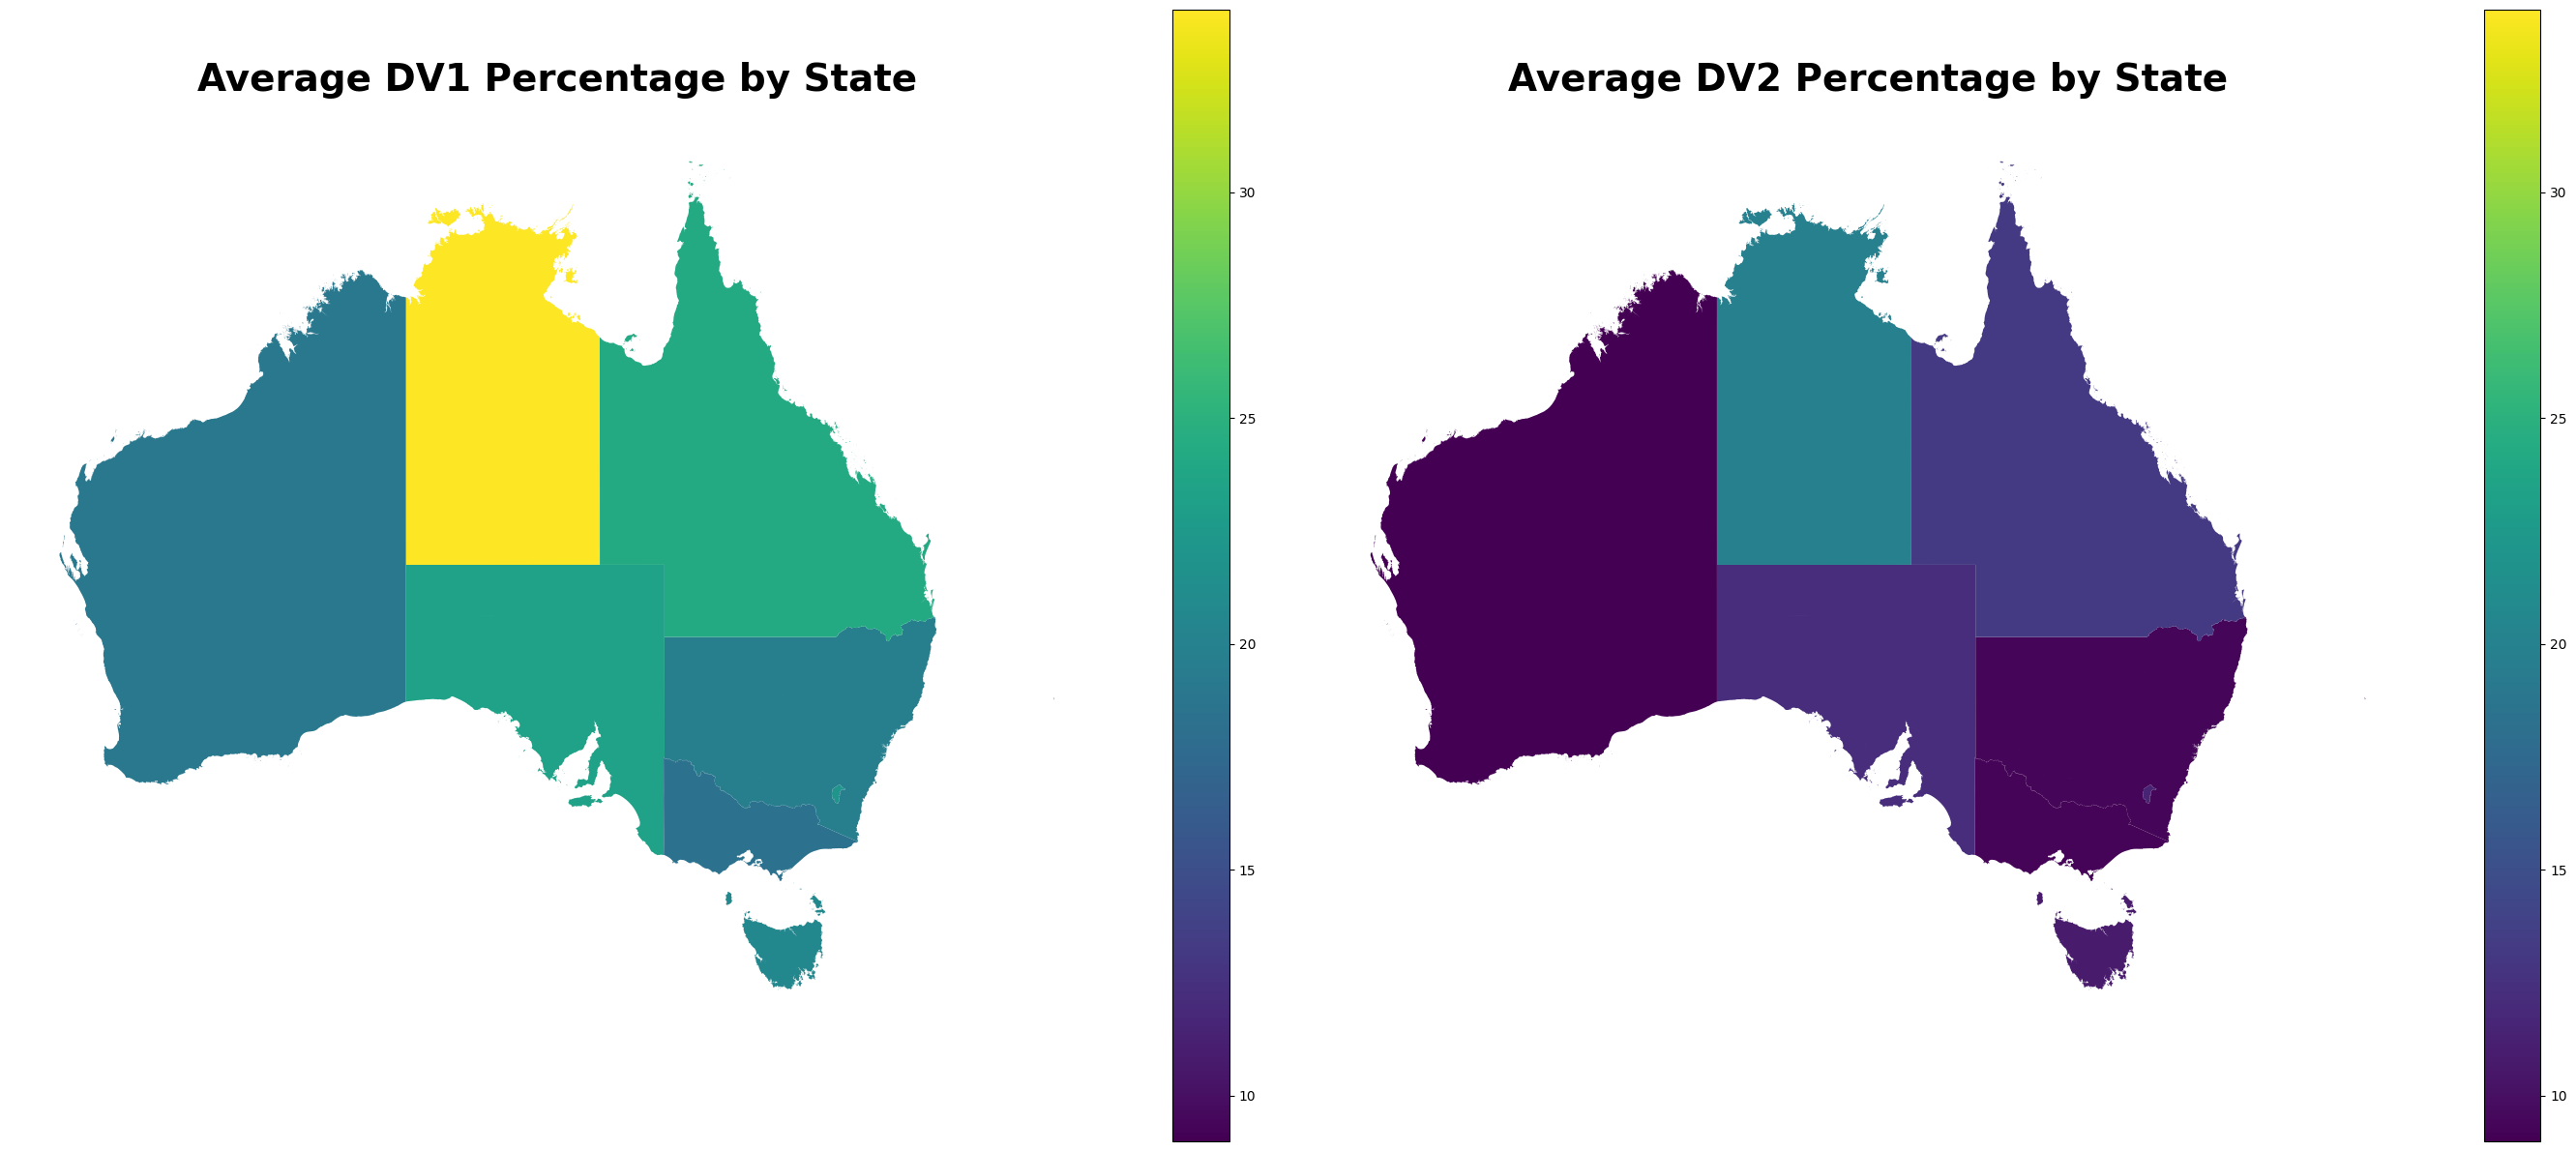

In [35]:
vmin_global = min(gdf_states['DV1_pct'].min(), gdf_states['DV2_pct'].min())
vmax_global = max(gdf_states['DV1_pct'].max(), gdf_states['DV2_pct'].max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))

gdf_states.plot(
    column='DV1_pct',
    ax=ax1,
    legend=True,
    cmap='viridis',
    vmin=vmin_global,
    vmax=vmax_global
)
ax1.set_title('Average DV1 Percentage by State', fontsize=28, fontweight='bold', pad=20)
ax1.axis('off')

gdf_states.plot(
    column='DV2_pct',
    ax=ax2,
    legend=True,
    cmap='viridis',
    vmin=vmin_global,
    vmax=vmax_global
)
ax2.set_title('Average DV2 Percentage by State', fontsize=28, fontweight='bold', pad=20)
ax2.axis('off')

plt.tight_layout()
plt.show()


## Q3 Distribution of Education Service and AEDC across LGAs 

In [36]:
# Convert Quality to Numeric (1-5)：Enables the  statistical comparisons and correlation analyses with other variables such as vulnerability rates and service accessibility.
quality_map = {
      'Exceeding NQS': 5,
      'Meeting NQS': 4,
      'Working Towards NQS': 3,
      'Significant Improvement Required': 2,
      'Not Rated': 1}
df['QualityScore'] = df['OverallRating'].map(quality_map)

calculate the total population for each LGA (Local Government Area) and compute per capita service metrics—while avoiding double-counting population when multiple services exist in the same suburb—the following steps were taken:

Remove duplicate suburb populations:
For each suburb, only one population value is kept to prevent counting the same people multiple times.

Aggregate population by LGA:
The population of all unique suburbs within each LGA is summed to get the total LGA population.

Calculate LGA-level service statistics:
For both DV1 and DV2 domains, the code calculates the number of services, average service quality, average accessibility, and average vulnerability percentage for each LGA.

Merge population data:
The total population for each LGA is merged into the LGA service statistics table.

Compute per capita metrics:
Using the total LGA population, the code calculates the number of services and accessibility per 1,000 people, making comparisons between LGAs of different sizes fairer.


In [37]:
df_dv1 = df[df['Domain'] == 'DV1'].copy()
df_dv2 = df[df['Domain'] == 'DV2'].copy()

suburb_pop = df[['Suburb', 'lga_code', 'Population']].drop_duplicates(subset=['Suburb'])
lga_pop = suburb_pop.groupby('lga_code', as_index=False)['Population'].sum()

# DV1
lga_stats_dv1 = df_dv1.groupby(['State', 'lga_code']).agg(
    num_services=('ServiceName', 'nunique'),
    avg_quality=('QualityScore', 'mean'),
    avg_capacity=('NumberOfApprovedPlaces', 'mean'),  
    avg_DV1_pct=('Domain_pct', 'mean')
).reset_index()

lga_stats_dv1 = lga_stats_dv1.merge(lga_pop, on='lga_code', how='left')
lga_stats_dv1['services_per_1000'] = lga_stats_dv1['num_services'] / lga_stats_dv1['Population'] * 1000
lga_stats_dv1['capacity_per_1000'] = lga_stats_dv1['avg_capacity'] / lga_stats_dv1['Population'] * 1000

# DV2
lga_stats_dv2 = df_dv2.groupby(['State', 'lga_code']).agg(
    num_services=('ServiceName', 'nunique'),
    avg_quality=('QualityScore', 'mean'),
    avg_capacity=('NumberOfApprovedPlaces', 'mean'),  #
    avg_DV2_pct=('Domain_pct', 'mean')
).reset_index()
lga_stats_dv2 = lga_stats_dv2.merge(lga_pop, on='lga_code', how='left')
lga_stats_dv2['services_per_1000'] = lga_stats_dv2['num_services'] / lga_stats_dv2['Population'] * 1000
lga_stats_dv2['capacity_per_1000'] = lga_stats_dv2['avg_capacity'] / lga_stats_dv2['Population'] * 1000

## Heatmap - Correlation between Service Variables and DV1/DV2 by State
correlation between DV1/DV2 and the three variables

In [38]:
states = df['State'].dropna().unique()
corrs = []

for state in states:
    sub_dv1 = lga_stats_dv1[lga_stats_dv1['State'] == state]
    sub_dv2 = lga_stats_dv2[lga_stats_dv2['State'] == state]
    corrs.append({
        'State': state,
        'DV1_num_services': sub_dv1['avg_DV1_pct'].corr(sub_dv1['num_services']),
        'DV1_quality': sub_dv1['avg_DV1_pct'].corr(sub_dv1['avg_quality']),
        'DV1_capacity': sub_dv1['avg_DV1_pct'].corr(sub_dv1['avg_capacity']), 
        'DV2_num_services': sub_dv2['avg_DV2_pct'].corr(sub_dv2['num_services']),
        'DV2_quality': sub_dv2['avg_DV2_pct'].corr(sub_dv2['avg_quality']),
        'DV2_capacity': sub_dv2['avg_DV2_pct'].corr(sub_dv2['avg_capacity']),
    })

corr_df = pd.DataFrame(corrs).set_index('State')
corr_df.head()

,DV1_num_services,DV1_quality,DV1_capacity,DV2_num_services,DV2_quality,DV2_capacity
State,,,,,,
QLD,0.075723,-0.051668,0.190512,0.004749,-0.212005,0.065765
NT,0.368613,-0.906421,-0.692557,0.336459,-0.899435,-0.666701
VIC,0.105036,-0.008982,0.138977,0.120602,-0.014878,0.060250
NSW,-0.090965,-0.178612,-0.255449,-0.145124,-0.213854,-0.273740
ACT,-0.661374,0.423740,0.424812,-0.676283,0.493114,0.429563


The correlation coefficients between AEDC outcomes (DV1 and DV2) and three education service variables (number of services, quality, and accessibility) for each state separately.

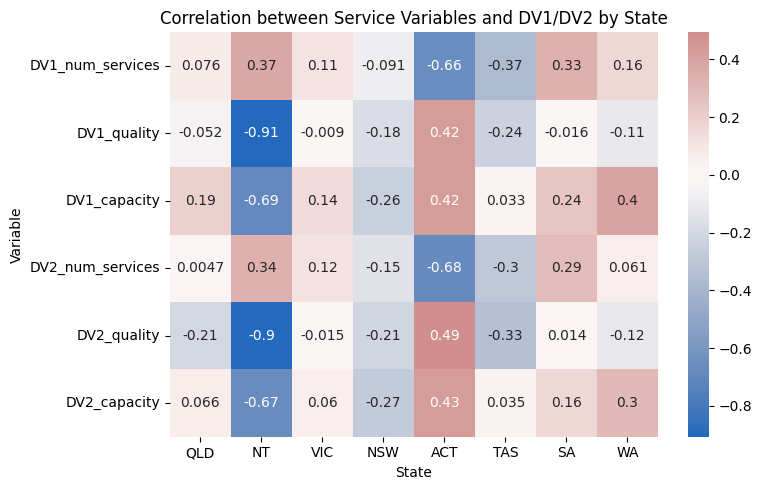

In [39]:
heatmap_df = corr_df.stack().unstack(0)
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, cmap='vlag', center=0)
plt.title('Correlation between Service Variables and DV1/DV2 by State')
plt.ylabel('Variable')
plt.xlabel('State')
plt.tight_layout()
plt.show()

## Scatter Plot: LGA Service Count, Quality, and Accessibility Compared to DV1 (Small) and DV2 (Large) Vulnerability

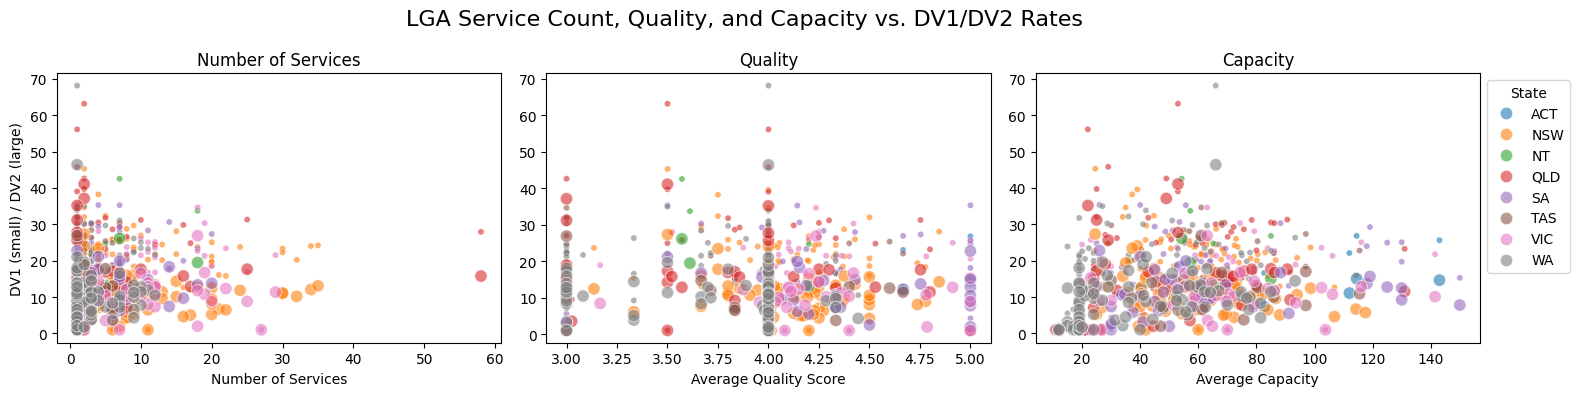

In [40]:
plt.figure(figsize=(15, 4))

# 1. Number of Services
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=lga_stats_dv1, x='num_services', y='avg_DV1_pct', hue='State', s=20, alpha=0.6, palette='tab10', ax=ax1, legend=False)
sns.scatterplot(data=lga_stats_dv2, x='num_services', y='avg_DV2_pct', hue='State', s=80, alpha=0.6, palette='tab10', ax=ax1, legend=False)
ax1.set_title('Number of Services')
ax1.set_xlabel('Number of Services')
ax1.set_ylabel('DV1 (small) / DV2 (large)')

# 2. Quality
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=lga_stats_dv1, x='avg_quality', y='avg_DV1_pct', hue='State', s=20, alpha=0.6, palette='tab10', ax=ax2, legend=False)
sns.scatterplot(data=lga_stats_dv2, x='avg_quality', y='avg_DV2_pct', hue='State', s=80, alpha=0.6, palette='tab10', ax=ax2, legend=False)
ax2.set_title('Quality')
ax2.set_xlabel('Average Quality Score')
ax2.set_ylabel('')

# 3. Capacity
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=lga_stats_dv1, x='avg_capacity', y='avg_DV1_pct', hue='State', s=20, alpha=0.6, palette='tab10', ax=ax3, legend=False)
sc = sns.scatterplot(data=lga_stats_dv2, x='avg_capacity', y='avg_DV2_pct', hue='State', s=80, alpha=0.6, palette='tab10', ax=ax3)
ax3.set_title('Capacity')
ax3.set_xlabel('Average Capacity')
ax3.set_ylabel('')

plt.suptitle('LGA Service Count, Quality, and Capacity vs. DV1/DV2 Rates', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.tight_layout()
# Only show the legend for the last subplot
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', title='State')
plt.show()


# Q4
Do LGAs with a higher percentage of education services rated as "Exceeding National Quality Standards" (NQS) show better AEDC outcomes, particularly in domains such as language and cognitive skills? What is the relationship between operational capacity (e.g., the number of children served) and developmental vulnerability indicators? What is the relationship between enrolment rates, attendance rates and developmental vulnerability indicators?

In [41]:
domains = ['Health','Social','Emotional','Language','Communication']
df_domains = df[
    (df['Domain'].isin(domains)) &
    (df['LGA_Year'] == '2021')
].copy()

lga_domain_scores = (
    df_domains
    .groupby(['lga_code','Domain'])['Domain_pct']
    .mean()
    .reset_index()
)
lga_domain_wide = (
    lga_domain_scores
    .pivot(index='lga_code', columns='Domain', values='Domain_pct')
    .reset_index()
    .dropna()
)

df_exceeding = df[df['QualityScore'] == 5].copy()

lga_total = (
    df
    .groupby('lga_code')
    .agg(total_services=('ServiceName','nunique'))
    .reset_index()
)
lga_exceeding = (
    df_exceeding
    .groupby('lga_code')
    .agg(exceeding_services=('ServiceName','nunique'))
    .reset_index()
)
lga_exceeding = (
    lga_total
    .merge(lga_exceeding, on='lga_code', how='left')
    .fillna({'exceeding_services': 0})
)
lga_exceeding['exceeding_pct'] = (
    lga_exceeding['exceeding_services'] /
    lga_exceeding['total_services']
)

# Merge “exceeding_pct” with 2021 AEDC domain percentages
lga_merged = lga_exceeding.merge(
    lga_domain_wide,
    on='lga_code',
    how='left'
)
lga_merged.head()

,lga_code,total_services,exceeding_services,exceeding_pct,Communication,Emotional,Health,Language,Social
0,10050,18,3.0,0.166667,9.7072,9.8765,11.4022,6.3174,12.3267
1,10250,9,7.0,0.777778,6.2189,8.7065,6.9652,6.7164,6.9652
2,10300,1,0.0,0.000000,16.6667,17.6471,33.3333,11.7647,17.6471
3,10600,4,1.0,0.250000,3.6036,7.2072,13.5135,7.2072,6.3063
4,10650,1,0.0,0.000000,6.6667,14.6067,18.8889,10.0000,13.3333


Filters services with a QualityScore of 5 (Exceeding), counts total and Exceeding services per lga_code, computes the proportion of Exceeding services, and merges that result with lga_domain_wide by lga_code.

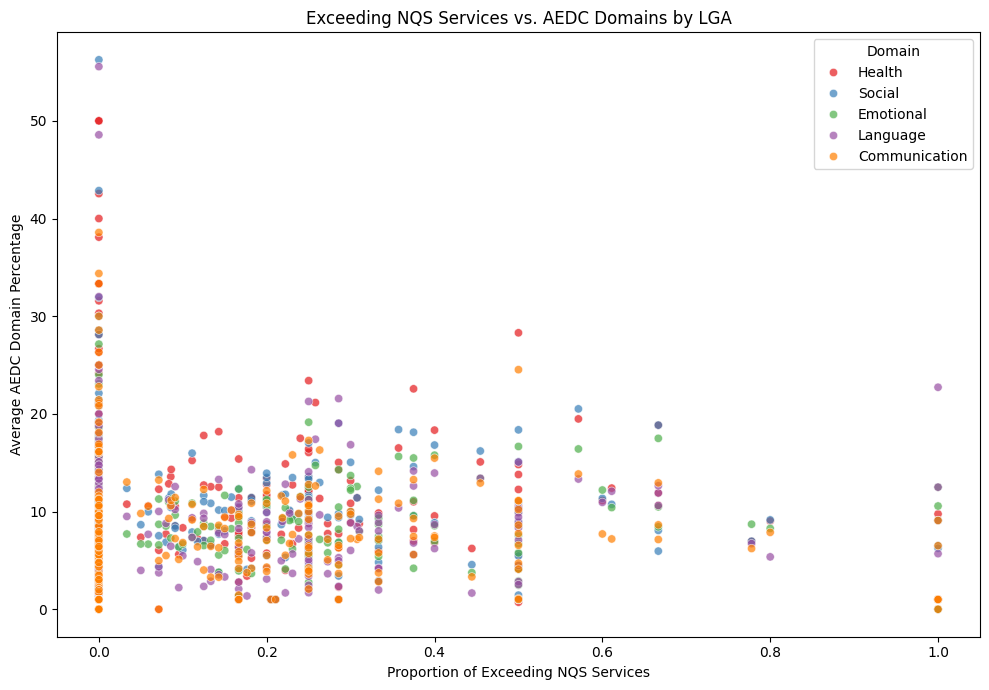

In [42]:
lga_long = lga_merged.melt(
    id_vars=['lga_code', 'exceeding_pct'],
    value_vars=domains,
    var_name='Domain',
    value_name='domain_pct'
)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=lga_long,
    x='exceeding_pct',
    y='domain_pct',
    hue='Domain',
    palette='Set1',
    alpha=0.7
)
plt.xlabel('Proportion of Exceeding NQS Services')
plt.ylabel('Average AEDC Domain Percentage')
plt.title('Exceeding NQS Services vs. AEDC Domains by LGA')
plt.legend(title='Domain')
plt.tight_layout()
plt.show()

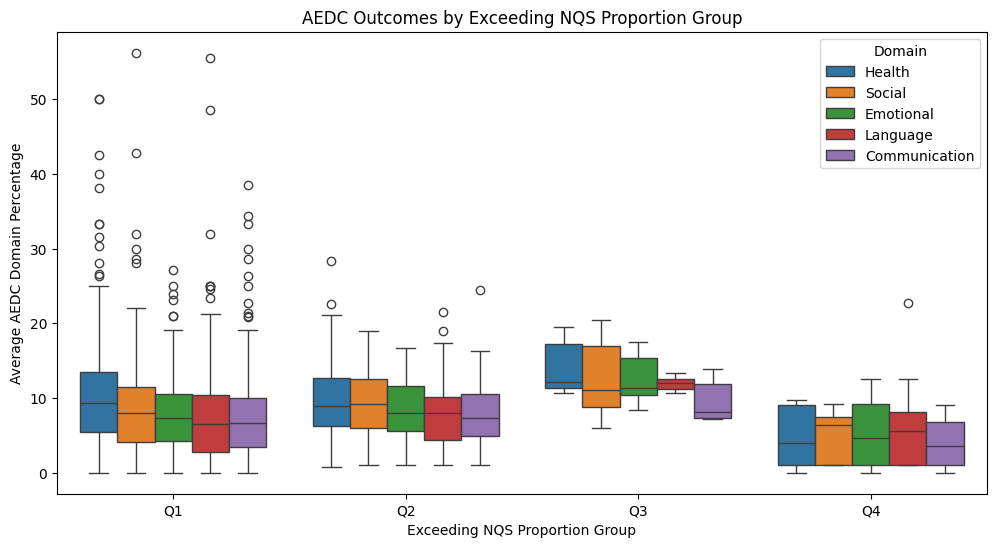

In [43]:
lga_long['exceeding_group'] = pd.cut(
    lga_long['exceeding_pct'],
    bins=4,
    labels=['Q1','Q2','Q3','Q4'],
    include_lowest=True
)
plt.figure(figsize=(12, 6))
sns.boxplot(x='exceeding_group', y='domain_pct', hue='Domain', data=lga_long)
plt.xlabel('Exceeding NQS Proportion Group')
plt.ylabel('Average AEDC Domain Percentage')
plt.title('AEDC Outcomes by Exceeding NQS Proportion Group')
plt.legend(title='Domain')
plt.show()

## Q4b 
What is the relationship between operational capacity (e.g., the number of children served) and developmental vulnerability indicators?

In [44]:
lga_capacity = (
    df.groupby('lga_code')
    .agg(total_capacity=('NumberOfApprovedPlaces', 'sum'))
    .reset_index()
)
lga_merged = lga_capacity.merge(
    lga_domain_wide,
    on='lga_code',
    how='left'
).dropna()

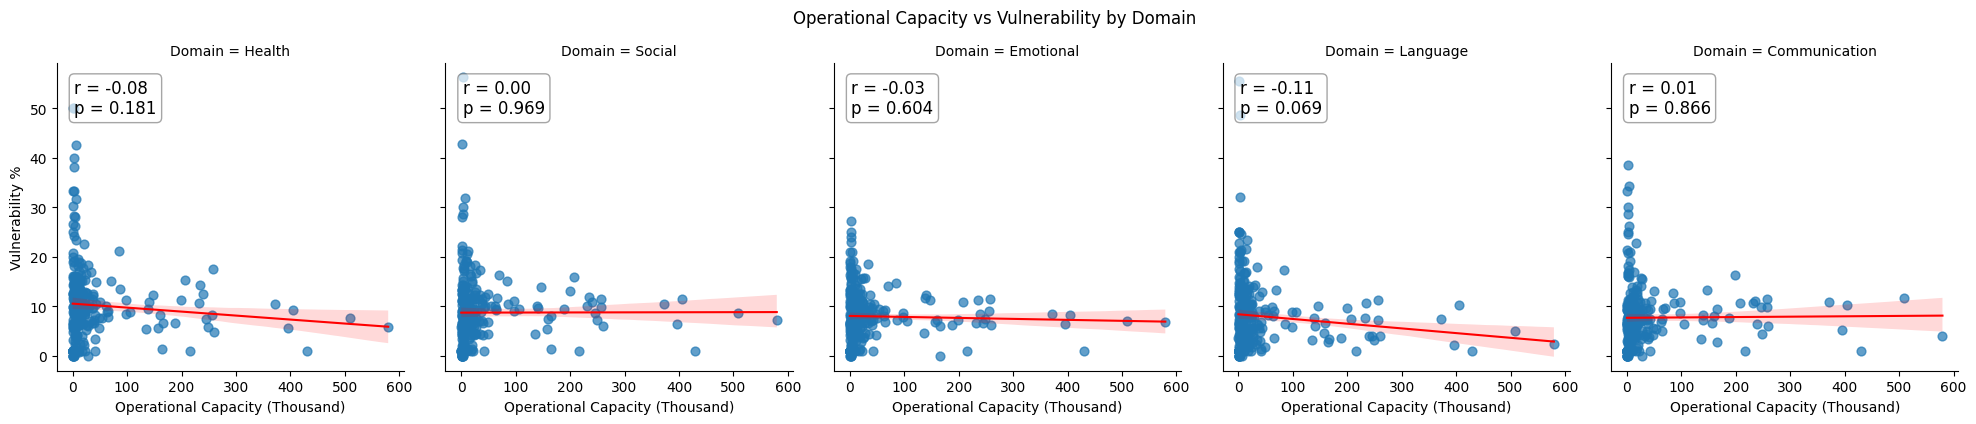

In [45]:
domains = ['Health','Social','Emotional','Language','Communication']
lga_long = lga_merged.melt(
    id_vars=['lga_code', 'total_capacity'],
    value_vars=domains,
    var_name='Domain',
    value_name='domain_pct'
)
g = sns.lmplot(
    data=lga_long,
    x='total_capacity',
    y='domain_pct',
    col='Domain',
    scatter_kws={'alpha': 0.7, 's': 40},
    line_kws={'color': 'red', 'lw': 1.5},
    height=4,
    aspect=1
)
for i, domain in enumerate(lga_long['Domain'].unique()):
    ax = g.axes[0, i]
    sub = lga_long[lga_long['Domain'] == domain]
    r, p = pearsonr(sub['total_capacity'], sub['domain_pct'])
    star = '*' if p < 0.05 else ''
    ax.text(
        0.05, 0.95, f"r = {r:.2f}{star}\np = {p:.3f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1, alpha=0.7)
    )
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: int(x/1000)))

g.set_axis_labels("Operational Capacity (Thousand)", "Vulnerability %")
plt.suptitle("Operational Capacity vs Vulnerability by Domain", y=1.05)
plt.show()

## Q4c 
What is the relationship between enrolment rates, attendance rates and developmental vulnerability indicators? 

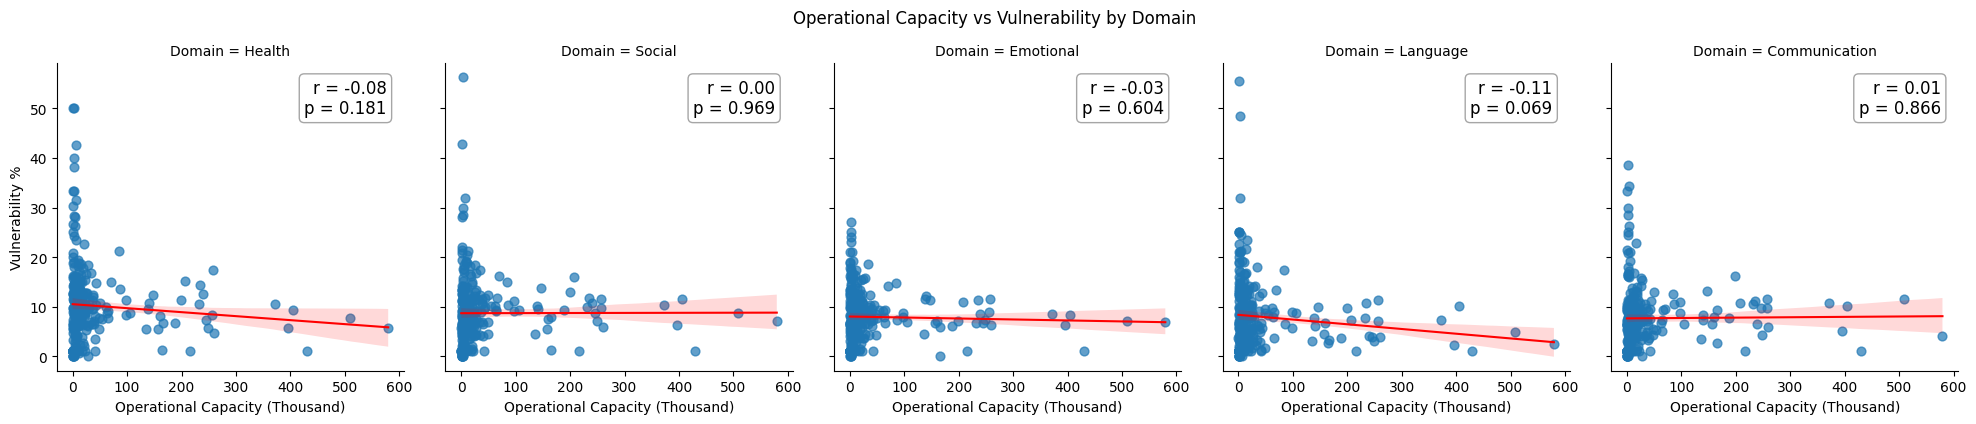

In [46]:
domains = ['Health','Social','Emotional','Language','Communication']
lga_long = lga_merged.melt(
    id_vars=['lga_code', 'total_capacity'],
    value_vars=domains,
    var_name='Domain',
    value_name='domain_pct'
)

g = sns.lmplot(
    data=lga_long,
    x='total_capacity',
    y='domain_pct',
    col='Domain',
    scatter_kws={'alpha': 0.7, 's': 40},
    line_kws={'color': 'red', 'lw': 1.5},
    height=4,
    aspect=1
)

for i, domain in enumerate(lga_long['Domain'].unique()):
    ax = g.axes[0, i]
    sub = lga_long[lga_long['Domain'] == domain]
    r, p = pearsonr(sub['total_capacity'], sub['domain_pct'])
    star = '*' if p < 0.05 else ''
    ax.text(
        0.95, 0.95, f"r = {r:.2f}{star}\np = {p:.3f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1, alpha=0.7)
    )
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: int(x/1000)))

g.set_axis_labels("Operational Capacity (Thousand)", "Vulnerability %")
plt.suptitle("Operational Capacity vs Vulnerability by Domain", y=1.05)
plt.show()

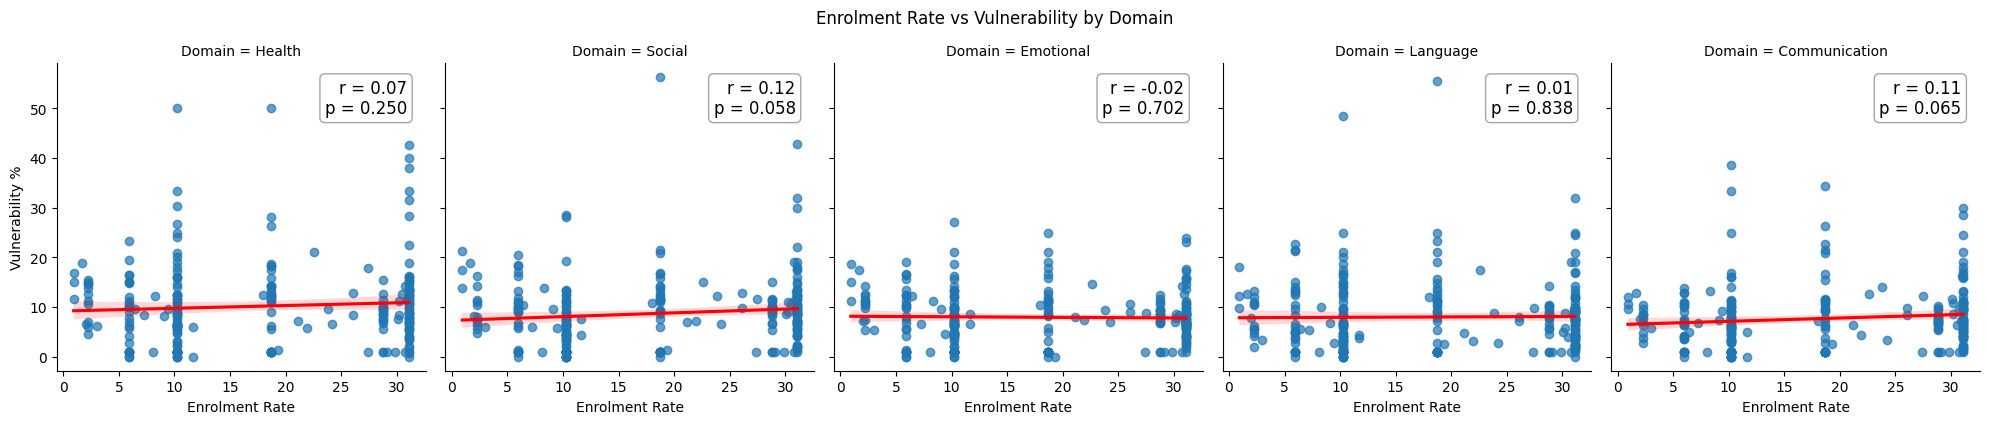

In [47]:
domains = ['Health', 'Social', 'Emotional', 'Language', 'Communication']

lga_rates = df.groupby('lga_code').agg(
    avg_enrolment=('Enrollment_pct', 'mean'),
    avg_attendance=('Attendance_pct', 'mean')
).reset_index()

lga_merged_rates = lga_rates.merge(lga_domain_wide, on='lga_code', how='left')

lga_long = lga_merged_rates.melt(
    id_vars=['lga_code', 'avg_enrolment', 'avg_attendance'],
    value_vars=domains,
    var_name='Domain',
    value_name='domain_pct'
)

g = sns.lmplot(
    data=lga_long,
    x='avg_enrolment',
    y='domain_pct',
    col='Domain',
    scatter_kws={'alpha':0.7},
    line_kws={'color':'red'},
    height=4,
    aspect=1
)

for i, domain in enumerate(lga_long['Domain'].unique()):
    ax = g.axes[0, i]
    sub = lga_long[lga_long['Domain'] == domain]
    r, p = pearsonr(sub['avg_enrolment'], sub['domain_pct'])
    star = '*' if p < 0.05 else ''
    ax.text(
        0.95, 0.95, f"r = {r:.2f}{star}\np = {p:.3f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1, alpha=0.7)
    )
    
g.set_axis_labels("Enrolment Rate", "Vulnerability %")
plt.suptitle("Enrolment Rate vs Vulnerability by Domain", y=1.05)
plt.show()

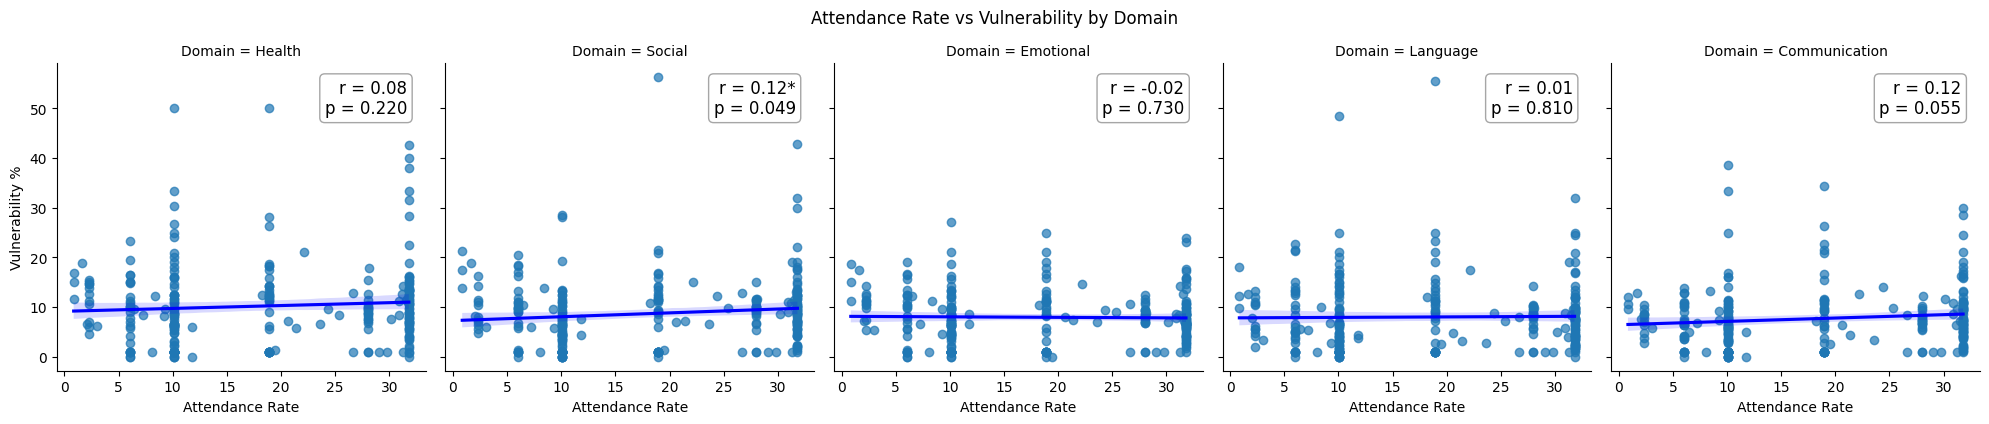

In [48]:
g = sns.lmplot(
    data=lga_long,
    x='avg_attendance',
    y='domain_pct',
    col='Domain',
    scatter_kws={'alpha':0.7},
    line_kws={'color':'blue'},
    height=4,
    aspect=1
)

for i, domain in enumerate(lga_long['Domain'].unique()):
    ax = g.axes[0, i]
    sub = lga_long[lga_long['Domain'] == domain]
    r, p = pearsonr(sub['avg_attendance'], sub['domain_pct'])
    star = '*' if p < 0.05 else ''
    ax.text(
        0.95, 0.95, f"r = {r:.2f}{star}\np = {p:.3f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1, alpha=0.7)
    )

g.set_axis_labels("Attendance Rate", "Vulnerability %")
plt.suptitle("Attendance Rate vs Vulnerability by Domain", y=1.05)
plt.show()